## Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [0]:
# Please fill in your names here
NAME_STUDENT_1 = "A. Siganos"
NAME_STUDENT_2 = "J. Gómez Robles"

In [4]:
# Preparing environment (We work on Google Colaboratory)

# Install all general packages
!pip install numpy scipy scikit-learn matplotlib pandas pillow graphviz scikit-image GPy pods

# Graphviz system level
!apt-get install -y graphviz

# Keras 
!pip install keras

# OpenML
!pip install git+https://github.com/renatopp/liac-arff@master
!pip install git+https://github.com/openml/openml-python.git@develop

# Getting directory
!if [ ! -d ML-course ]; then git clone https://github.com/joaquinvanschoren/ML-course.git; else echo "Repo already cloned"; fi;
!cp -r ML-course/* .

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/renatopp/liac-arff (to master) to /tmp/pip-9ahal93j-build
  Cloning https://github.com/openml/openml-python.git (to develop) to /tmp/pip-992dhli0-build
Repo already cloned


In [5]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all" 
HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Support Vector Bananas (4 points (2+2))
We will first explore SVM kernels and hyperparameters on an artificial dataset representing multiple banana shapes. 

In [0]:
from sklearn.model_selection import *
bananas = oml.datasets.get_dataset(1460) # Download banana data
X, y = bananas.get_data(target=bananas.default_target_attribute);
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/4)

1 . Evaluate how well an SVM classifier can fit the data. 

- Use a linear, polynomial and radial basis function (RBF) kernel, using their default hyperparameters. Evaluate the performance of each kernel using the test set and AUC. Which one works best? 
- Visualize the results using the visualization code also used in class (under mglearn/plot_svm.py > plot_svm_kernels). Also show the AUC score and the number of support vectors. Explain intuitively how well the data is fitted, why the kernel is (not) able to fit the data, whether it is under- or overfitting, etc.

In [0]:
################################################################################
################################## RUN FIRST  ##################################
################################################################################


from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import math 

def scaleData(X_train, X_test):
  min_on_training = X_train.min(axis = 0)  
  # Compute the range of each feature (max - min) on the training set
  range_on_training = (X_train - min_on_training).max(axis = 0)
  # subtract the min, divide by range
  # afterwards min=0 and max=1 for each feature
  X_train_scaled = (X_train - min_on_training) / range_on_training
  X_test_scaled = (X_test - min_on_training) / range_on_training
  
  # Return both
  return X_train_scaled, X_test_scaled

def plotModel(clf, label, X_train, y_train, X_test, y_test):
  # plot the line, the points, and the nearest vectors to the plane
  fig = plt.figure(label, figsize = (10, 10))  
  plt.title("SVC with kernel '{}' (default parameters).\nNumber of support vectors: {}".format(
      label, clf.support_vectors_.shape[0]))

  # Plot support vectors as withe dots (bigger than the others)
  plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
              s = 100, edgecolors='k', c = 'w', zorder = 10)
  
  # Plot the data that generated the model
  plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, zorder = 10, cmap = plt.cm.bwr)

#   for i, coef in enumerate(clf.dual_coef_[0]):
#       plt.annotate("%0.2f" % (coef), (clf.support_vectors_[i, 0]+0.15, clf.support_vectors_[i, 1]), fontsize=8, zorder=11)
  
#   plt.axis('tight')
  x_min = 0
  x_max = 1
  y_min = 0
  y_max = 1

  XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
  Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
#   Z = clf.decision_function(X_train)
#   print(Z.shape)
# #   # Put the result into a color plot
  Z = Z.reshape(XX.shape)
  plt.figure(label, figsize=(10, 10))
  plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
              levels=[-.5, 0, .5])
#   plt.contour(X_test[:, 0], X_test.T[0, :], Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
#               levels=[-.5, 0, .5])

#   plt.xlim(x_min, x_max)
#   plt.ylim(y_min, y_max)

#   plt.xticks(())
#   plt.yticks(())
#   plt.show()


def runSVC(model, X_train, y_train, X_test, y_test, label = None, plot = False):
  model.fit(X_train, y_train)
  if plot :
    plotModel(model, label, X_train, y_train, X_test, y_test)
  # Return AUC score for test set
  return roc_auc_score(y_test, model.decision_function(X_test))

In [104]:
X_train.shape

(3975, 2)

,Kernel,AUC score
0,linear,0.47
1,rbf,0.58
2,poly,0.64


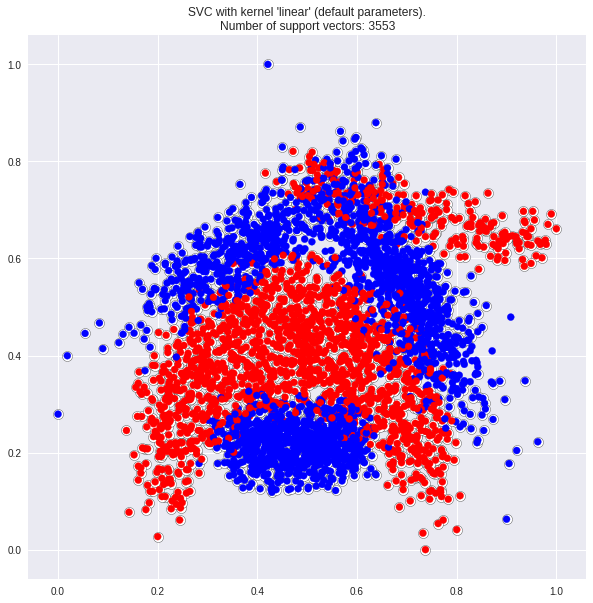

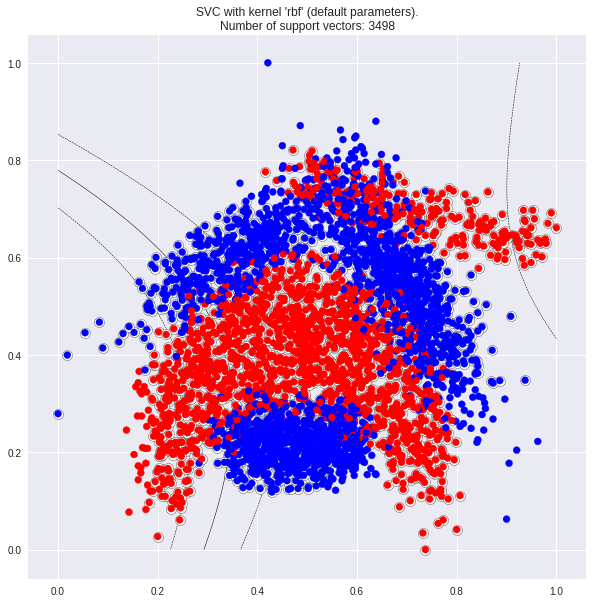

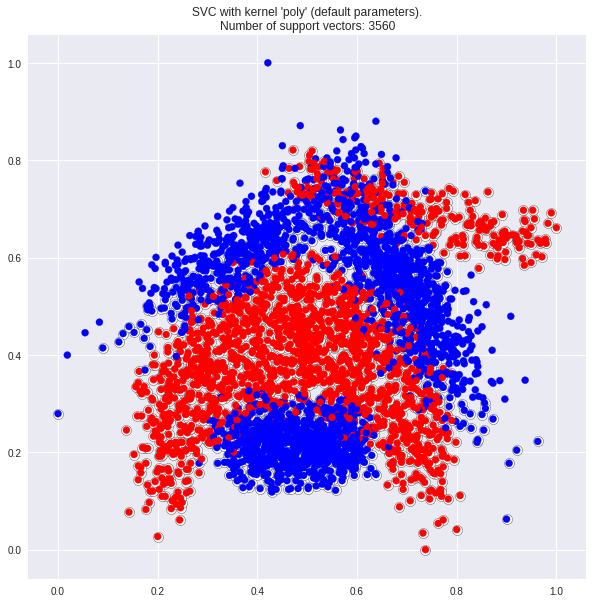

In [121]:
# 1a) Use a linear, polynomial and radial basis function (RBF) kernel, using 
#     their default hyperparameters. Evaluate the performance of each kernel 
#     using the test set and AUC. Which one works best?

# 0. Variables
classifiers = { "linear": SVC(kernel = "linear"), 
               # Default is rbf, but better to be explicit :)
               "rbf" : SVC(kernel = "rbf"), 
               "poly" : SVC(kernel="poly")
              }

# 1. Scale data (better results)
X_train_scaled, X_test_scaled = scaleData(X_train, X_test)


# 2. Fit all models and get scores
results = []
for name, model in classifiers.items():
  auc_score = runSVC(model, 
                     X_train_scaled, y_train, 
                     X_test_scaled, y_test, 
                     name, True)
  results.append([name, auc_score])

# 3. Show AUC scores
pd.DataFrame(results, columns = ["Kernel", "AUC score"])


2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 

- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results snd report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.

In [125]:
# 2a. Manual tunning

# 0. Variables
params = { 'C' : [0.01, 1.0, 1000], # Default is 1.0
           'gamma' : [0.01, 'auto', 1000]
         }

# 1. Scale data (better results)
X_train_scaled, X_test_scaled = scaleData(X_train, X_test)

results = []
# 2. Run for each of the 9 combinations
for c in params['C']:
  for gamma in params['gamma']:  
    rfbSVC = SVC(C = c, gamma = gamma)
    auc_score = runSVC(rfbSVC, X_train_scaled, y_train, X_test_scaled, y_test)
    results.append([c, gamma, auc_score])

pd.DataFrame(results, columns = ["C", "gamma", "AUC score"])


,C,gamma,AUC score
0,0.01,0.01,0.53
1,0.01,auto,0.57
2,0.01,1000,0.96
3,1.00,0.01,0.64
4,1.00,auto,0.58
5,1.00,1000,0.94
6,1000.00,0.01,0.56
7,1000.00,auto,0.91
8,1000.00,1000,0.93


In [0]:
def runGridSearch(model, X_train, y_train, params, cv = 10, plot = True):
  
  # Do the GridSearch with cross-validation
  grid_search = GridSearchCV(model, params, cv = cv, verbose = 1, n_jobs = 16, 
                             scoring = "roc_auc")
  grid_search.fit(X_train, y_train)
  
  # If plot is requested, plot heatmap
  if plot :
    results = pd.DataFrame(grid_search.cv_results_)
    keys = list(params)
    scores = np.array(results.mean_test_score).reshape( 
        len(params[keys[0]]), len(params[keys[1]]) )
    fig, axis = plt.subplots(figsize = (15, 15))
    axis.set_xticklabels(params[keys[1]], rotation = 90)
    mglearn.tools.heatmap(scores, ylabel = keys[0], yticklabels = params[keys[0]],
                      xlabel = keys[1], xticklabels = params[keys[1]], 
                          cmap="viridis", ax = axis);     
  
  # Return only scores and paramters
  return grid_search.best_score_, grid_search.best_params_

# 2b. GridSearch
gridValues = [2 ** x for x in range(-15, 15, 2)]
# gridValues = [2 ** x for x in range(-15, 15, 2)]
params = { 'C' : gridValues, # Default is 1.0
           'gamma' : gridValues
         }

# 1. Scale data (better results)
X_train_scaled, X_test_scaled = scaleData(X_train, X_test)

best_score, best_params = runGridSearch(SVC(), X_train_scaled, y_train, params)

print("SVC-RBF best score: {}\nSVC-RBF best parameters: {}".format(
    best_score, best_params))

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   20.9s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  4.9min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  8.9min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed: 13.7min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed: 19.2min


## Building Kernels (4 points (0.5+0.5+1+2))

Consider the artificial dataset given below. It represents a sine wave with added noise.

1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions on all data points in [0, 40]. 

    - Does it fit the data well? Does it extrapolate well (in the range [30,40])? Explain your findings. 
    - Can you get better results by tweaking the kernel or the other SVM parameters?
    
2. Implement your own linear kernel. This is a function that takes 2 vectors (arrays) and returns the dot product:

      $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$$
    - Build an SVM regressor using that kernel by passing your kernel function as the `kernel` hyperparameter. 
    - Fit it on the sine data and plot the predictions on all data points. Interpret the results.
    
3. Since this data is periodic, it makes sense to implement a periodic kernel instead. 

    - This is the Exponential Sine Squared kernel, with length scale $\Gamma$ and periodicity $P$:
  $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\Gamma\,\sin^2\left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]\right)$$
    - Implement it, using the defaults $\Gamma=1$, periodicity $P=1$, and Euclidean distance.
    - Train an SVM regressor with it, fit in on the same data and plot the result. Interpret the outcome. 
    - Think about what $\Gamma$ and $P$ represent. Can you improve the fit by manually adjusting them? Explain your findings.
    - Optimize $\Gamma$ and periodicity $P$ (using `true_y` as the ground truth). Use a grid search or random search, $\Gamma \in [0,1]$, $P \in [1,100]$, try at least 5 values for each.

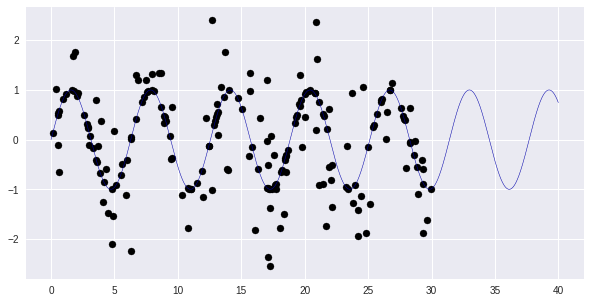

In [24]:
# Generate sample data
rng = np.random.RandomState(0) # Random seed, for reproducibility 
X = 30 * rng.rand(200, 1)
y = np.sin(X).ravel() 
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2) # adds noise

X_plot = np.linspace(0, 40, 10000)[:, None] # A larger range to evaluate on
true_y = np.sin(X_plot) # and the 'true' target function

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

In [0]:
# 1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions
#    on all data points in [0, 40].
from sklearn.svm import SVR

svmr = SVR()
svrm.fit(X)

4 . We now make the problem a bit more challenging by adding an upward trend:

- Fit the same SVM using the optimal parameters from the previous subtask and plot the results. Do they still work? Explain what you see.
- Fit a Gaussian process (GP) using the kernels given below. First use the singular ExpSineSquared kernel (the implementation provided by sklearn this time), then build a new kernel consisting of the 3 components given below. Use both to predict all points for the "rising noisy sine" data and plot the results as usual. Interpret the results.
    - For the GP, it may help to use `normalize_y=True` since the y-values are not around 0. Setting `alpha=0.1` may help with possible numerical issues, otherwise keep it at 0.
- Also plot the _uncertainty interval_ around the predictions. You can ask the GP to return the standard deviation during prediction with the `return_std=True` hyperparameter. Plot a band 2 standard deviations above and below the prediction. You can use MatPlotLib's `fill_between` as shown in class.
    - You can combine the 3 models in one plot for easy comparison.
- We've provided reasonable values for the kernel hyperparameters above. Can you optimize them further to get an even better fit? Think about what the hyperparameters do and optimize the ones you think are most worth tuning.

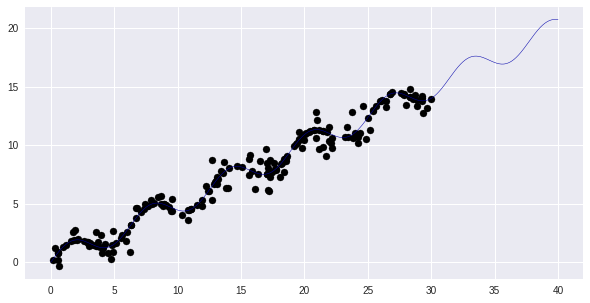

In [22]:
# Generate sample data with added trend
rng = np.random.RandomState(0)
X = 30 * rng.rand(200, 1)
y = X.ravel()/2 + np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2)  # add noise

X_plot = np.linspace(0, 40, 10000)[:, None]
true_y = X_plot/2 + np.sin(X_plot)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

In [0]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF

# Replace `length_scale` and `periodicity` with the values found in the previous part.
kernel_simple = ExpSineSquared(length_scale=1, periodicity=1) # periodic component

k1 = 4300 * RBF(length_scale=70.0)  # long term smooth rising trend
k2 = 6 * RBF(length_scale=90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # periodic component
k3 = 0.03 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.035)  # noise terms

## Bayesian updates (3 points (2+1))

We consider real data about solar radiation measured by a weather balloon:
https://www.openml.org/d/512. We'll use only the raw data (at least the first 1000 points) and try to learn the (very noisy) trend. 

1. Train a Gaussian process on an increasing amount of samples of the training data. Use a simple RBF kernel:
`RBF(10, (1e-2, 1e2))`

 - Start with 10 _random_ samples and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Also compute $R^2$ on the training data.
 - Repeat and 10 more points, retrain and redraw. Do this a couple of times and interpret/explain what you see. 
 
2. Train the Gaussian on the full training set.

 - Plot the predictions (including the uncertainty interval) on the full dataset. Evaluate on the test set using $R^2$ 
 - Interpret the results. Is the kernel right? Is the GP under/overfitting?
 - Try to improve the results by tuning the kernel. Do this either manually or using a small grid/random search.

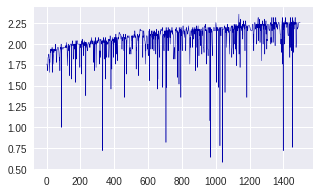

In [10]:
# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);

train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1250)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T

pd.Series(X[:1500,0]).plot()

## A data mining challenge (4 points)

The goal here is to use everything you have learned to build the best model for a given classification task. We will use two tasks hosted on OpenML, so you will all receive the same cross-validation splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection, pipeline building, and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial. You need to optimize the AUROC score (calculated using 10-fold cross0-validation).

- Challenge 1: Detects accents in speech data.

    - The OpenML Task ID is 167132: https://www.openml.org/t/167132
    - The dataset description can be found here: https://www.openml.org/d/40910
    - Leaderboard: https://www.openml.org/t/167132#!people
    
- Challenge 2: Image recognition (CIFAR-10 subsample).

    - The OpenML Task ID is 167133: https://www.openml.org/t/167133
    - The dataset description can be found here: https://www.openml.org/d/40926
    - Leaderboard: https://www.openml.org/t/167133#!people
    - Note that this is a high-dimensional dataset (and not so small). Think carefully about how to run experiments in the  time available.
    
- You are able to see the solutions of others (by clicking in the timeline or run list), so you can learn from prior experiments (what seems to work, how long does it take to train certain models, ...). Resubmission of the exact same solution is not possible.
- You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- Document the different experiments that you ran in this notebook (running them can of course be done outside of the notebook). For each experiment, provide a description of how and why you chose the algorithms and parameters that you submitted. Reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows (independently for each task):

    - 1 point for the breadth of experiments you ran (algorithms, pipelines, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Exception: simply repeating top models with nearly identical hyperparameters. This will be checked on the timeline.
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the leaderboard.
        
Note: Report the AUC scores of your best models in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.